# GPT from scratch (but very very small)
In this notebook we will build a GPT-style transformer from scratch. Heavily based on [nanoGPT](https://github.com/karpathy/nanoGPT) and [minGPT](https://github.com/karpathy/minGPT/tree/master) by Andrej Karpathy.

Emphasis on readable code, minimal and simple implementations, and (relatively) fast training.

In [24]:
import math
import pickle
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import RandomSampler, random_split

DEVICE = torch.device('cuda') # 'mps' for ARM macbooks, 'cuda' for colab, 'cpu' otherwise

## Data
We use the tiny shakespeare dataset to train a character level transformer to predict text that looks like shakespeare. All data is in one text file, which we download below.

In [3]:
!wget -nc https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

File ‘input.txt’ already there; not retrieving.



In [25]:
class CharacterTokenizer:
    """Character level tokenizer that enumerates the first 256 unicode characters"""
    def __init__(self):
        self.vocab_size = 256
        self.encoding_dict = {chr(token_i): token_i for token_i in range(256)}
        self.decoding_dict = {token_i: chr(token_i) for token_i in range(256)}

    def __repr__(self):
        return f'CharacterTokenizer(vocab_size={self.vocab_size})'

    def get_vocab(self) -> dict[str, int]:
        return self.encoding_dict

    def encode(self, data: str) -> list[int]:
        """Convert text to tokens"""
        return [self.encoding_dict.get(char, -1) for char in data]

    def decode(self, tokens: list[int]) -> str:
        """Convert tokens to text"""
        return ''.join(self.decoding_dict.get(token, '<unk>') for token in tokens)

class CharacterDataset:
    def __init__(self, data: str, tokenizer: CharacterTokenizer, context_size: int=256):
        self.data = data
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.get_vocab())
        self.context_size = context_size

    def __repr__(self):
        n_chars = len(self.data)
        vocab_size = self.vocab_size
        context_size = self.context_size
        return f'CharacterDataset({n_chars=}, {vocab_size=}, {context_size=})'

    @classmethod
    def from_textfile(cls, filename: str, context_size: int=256) -> 'CharacterDataset':
        """Load a textfile and automatically 'train' a character level tokenizer"""
        tokenizer = CharacterTokenizer()
        with open(filename, 'r') as fh:
            data = fh.read()
            return cls(data, tokenizer, context_size=context_size)

    def __len__(self) -> int:
        return len(self.data) - self.context_size

    def __getitem__(self, pos: int) -> torch.tensor:
        """Return tokens starting at pos up to pos + context_size, targets are shifted by one position"""
        # grab a chunk of block_size characters from the data
        chunk = self.data[pos:pos + self.context_size + 1]
        # encode every character to an integer
        tokens = self.tokenizer.encode(chunk)
        # convert to tensor
        tokens = torch.tensor(tokens, dtype=torch.long)
        # targets are shifted one position from input
        return tokens[:-1], tokens[1:]

dataset = CharacterDataset.from_textfile('./input.txt')
len(dataset)

1115138

## Model
The code below implements a full GPT-style model. All code is in one block to prevent mistakes when changing/updating parts of the implementation. The main functionality is implemented in a few classes (most are similar/identical to the 'naive transformer' we implemented earlier).

- `MultiheadDotProductAttention`: Full-blown multihead attention that takes batched input. Evenly chunks channels over heads, so number of channels must be dividable by number of heads.
- `PositionwiseMLP`: Position-wise multilayer perceptron to perform communication between channels after multihead attention. This ensures additional communication between heads after attention is calculated (attention only performs linear projection of heads).
- `TransformerBlock`: Executes the `DotProductSoftmaxAttention` and `FeedforwardMLP` in order, both with layer normalization to keep our gradients well-behaved, and both with a residual connection to let the original signal flow through (which includes for example positional information).
- `AdditivePositionalEmbedding`: A wrapper class to add positional embeddings to previously determined token embeddings.
- `GPT`: Combines all of the above functionality and adds dropout and layer normalization in a few places to help with generalization and prevent overfitting. In addition this implements the `generate` method so we can easily sample novel token sequences.

### Exercise 1
Take a brief (±5min) look at the provided `MultiHeadDotProductAttention` implementation and convince yourself (and/or your neighbor) that the underlying attention mechanisms is the same as we saw in the earlier 'naive' transformer, but that we have added functionality for multiple heads, batched inputs, and random dropout.

### Exercise 2
Implement the `TransformerBlock` class so that it:
- Calculates attention with `MultiHeadDotProductAttention`
- Communicates between channels using the `PositionwiseMLP`
- Includes layer normalization (using [nn.LayerNorm](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html))
- Adds residual connections

If you have properly implemented the 'TransformerBlock' the codeblock below will be able to generate a token sample from an untrained model when executed.

> _Tip:_ start by checking the already filled in `__init__` signatures of the `TransformerBlock`, `MultiHeadDotProduct`, and `PositionwiseMLP` classes. This will give you good hints on what parameters should be used where.


In [33]:
class MultiheadDotProductAttention(nn.Module):
    """Multihead dot product softmax attention"""
    def __init__(self, embedding_dim: int, n_heads: int, dropout: float):
        super().__init__()
        if embedding_dim % n_heads != 0:
            raise Exception('n_heads must be dividable by n_embed')

        self.n_heads = n_heads

        # attention input projections
        self.w_q = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)
        self.w_k = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)
        self.w_v = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)

        # output projection
        self.out_project = nn.Linear(in_features=embedding_dim, out_features=embedding_dim)

        #dropouts
        self.attention_dropout = nn.Dropout(dropout)
        self.projection_dropout = nn.Dropout(dropout)

    def forward(self, x: torch.tensor) -> torch.tensor:
        """Calculate multihead attention, expects input of shape (batch, context_length, embedding_dim)"""
        batch_dim, context_length, embedding_dim = x.size()

        # calculate input projections and divide over heads
        # 'view' and 'transpose' reorder in subtly different ways and we need both
        # (B, L, n_heads, head_dim) -> (B, n_heads, L, head_dim)
        q = self.w_q(x).view(batch_dim, context_length, self.n_heads, embedding_dim // self.n_heads).transpose(1,2)
        k = self.w_k(x).view(batch_dim, context_length, self.n_heads, embedding_dim // self.n_heads).transpose(1,2)
        v = self.w_v(x).view(batch_dim, context_length, self.n_heads, embedding_dim // self.n_heads).transpose(1,2)

        # calculate attention
        # (B, n_heads, L, head_size) x (B, n_heads, head_size, L) -> (B, n_heads, L, L)
        attention = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(embedding_dim))
        # Apply causal attention mask
        mask = torch.triu(torch.ones(context_length, context_length, dtype=torch.bool, device=q.device), diagonal=1)
        attention = attention.masked_fill(mask, -torch.inf)

        # Calculate row-wise logits
        attention = F.softmax(attention, dim=-1)

        # Random dropout of the attention matrix
        attention = self.attention_dropout(attention)

        # weight outputs with calculated attention
        # (B, n_heads, L, L) x (B, n_heads, L, head_dim) -> (B, n_heads, L, head_dim)
        pred = attention @ v

        # reshape multiple heads back into contiguous representation
        pred = pred.transpose(1, 2).contiguous().view(batch_dim, context_length, embedding_dim)

        # return linear projection
        return self.projection_dropout(self.out_project(pred))

class PositionWiseMLP(nn.Module):
    """Position-wise feedforward MLP: simple multi-layer perceptron for position-wise exchange of information between channels"""
    def __init__(self, embedding_dim: int, dropout: float):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=4*embedding_dim),
            nn.ReLU(),
            nn.Linear(in_features=4*embedding_dim, out_features=embedding_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.mlp(x)

class TransformerBlock(nn.Module):
    """Transformer block that combines attention and FeedforwardMLP,
    both with layer normalization and residual connections"""
    def __init__(self, embedding_dim: int, n_heads:int, dropout:float):
        super().__init__()
        self.attention = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            MultiheadDotProductAttention(
                embedding_dim=embedding_dim,
                n_heads=n_heads,
                dropout=dropout
            )
        )
        self.mlp = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            PositionWiseMLP(embedding_dim=embedding_dim, dropout=dropout)
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        """Calculate attention and communication between channels, both with residual connections"""
        # Communicate between positions (i.e. attention)
        attn = self.attention(x) + x
        # Communicate between embedding dimensions (i.e. channels)
        res = self.mlp(attn) + attn
        return res

class AdditivePositionalEmbedding(nn.Module):
    """Wrapper class to add positional encoding to already embedded tokens"""
    def __init__(self, context_size: int, embedding_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=context_size, embedding_dim=embedding_dim)

    def forward(self, x: torch.tensor) -> torch.tensor:
        """Add positional embeddings based on input dimensions, use residual connection"""
        pos = torch.arange(0, x.size(1), dtype=torch.long, device=x.device)
        return self.embedding(pos) + x

class GPT(nn.Module):
    def __init__(
        self,
        context_size: int,
        tokenizer: CharacterTokenizer,
        n_layers: int=6,
        n_heads: int=8,
        embedding_dim: int=32,
        dropout: float=0.1
    ):
        super().__init__()
        self.context_size = context_size
        self.vocab_size = tokenizer.vocab_size
        self.tokenizer = tokenizer
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.embedding_dim = embedding_dim
        self.dropout = dropout

        # transformer architecture (ref. our naive transformer, only difference is in the transformer block)
        self.transformer = nn.Sequential(
            nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=embedding_dim),
            AdditivePositionalEmbedding(context_size, embedding_dim),
            nn.Dropout(dropout),
            nn.Sequential(*[
                TransformerBlock(embedding_dim=embedding_dim, n_heads=n_heads, dropout=dropout)
                for _ in range(n_layers)
            ]),
            nn.LayerNorm(embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=self.vocab_size)
        )

        # weight tying of input embedding and output projection (https://paperswithcode.com/method/weight-tying)
        self.transformer[0].weight = self.transformer[-1].weight

        # initialize all weights
        self.apply(self._init_weights)

    def __repr__(self) -> str:
        context_size = self.context_size
        vocab_size = self.vocab_size
        n_attention_layers = self.n_layers
        n_heads = self.n_heads
        embedding_dim = self.embedding_dim
        dropout = self.dropout
        num_params = sum(p.numel() for p in self.parameters())
        return f'GPT({num_params=}, {context_size=}, {vocab_size=}, {n_attention_layers=}, {n_heads=}, {embedding_dim=}, {dropout=})'

    def save(self, filename: str = 'model.pkl') -> None:
      init_params = {k:v for k,v in self.__dict__.items() if k[0] != '_' and k not in ['training','tokenizer','vocab_size']}
      state_dict = {k: v.to('cpu') for k, v in self.state_dict().items()}
      param_dict = dict(init_params=init_params, state_dict=state_dict)

      with open(filename,'wb') as fh:
        pickle.dump(param_dict, fh)

    @classmethod
    def load_pretrained(cls, filename: str = 'model.pkl') -> 'GPT':
      with open(filename,'rb') as fh:
        param_dict = pickle.load(fh)
      model = cls(**param_dict['init_params'], tokenizer=CharacterTokenizer())
      model.load_state_dict({k:v.to(DEVICE) for k,v in param_dict['state_dict'].items()})
      return model


    def forward(self, tokens: torch.Tensor, targets: torch.Tensor=None) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        logits = self.transformer(tokens)
        loss = None if targets is None else F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        accuracy = None if targets is None else (logits.argmax(dim=-1) == targets).sum() / targets.numel()
        return logits, loss, accuracy

    def _init_weights(self, module: nn.Module) -> None:
        """Empirically this seems to be a good way to initialize"""
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def generate(self, prompt: str = None, sample_length: int=256) -> list[int]:
        """Generate sample tokens"""
        self.eval()
        device = next(self.parameters()).device
        if prompt is None:
            tokens = torch.zeros(1, dtype=torch.long, device=device)
        else:
            tokens = torch.tensor(self.tokenizer.encode(prompt), dtype=torch.long, device=device)

        for _ in trange(sample_length, desc='Sampling'):
            logits,_,_ = self(tokens[-self.context_size:][None])
            logits = logits[0,-1,:]

            probs = F.softmax(logits, dim=0)

            next_token = torch.multinomial(probs, num_samples=1)
            tokens = torch.cat([tokens, next_token])
        tokens = tokens.tolist() # move from tensor on gpu to list on cpu
        return self.tokenizer.decode(tokens)

tokenizer = CharacterTokenizer()
model = GPT(context_size=dataset.context_size, tokenizer=tokenizer)
print(dataset)
print(model)
sample = model.generate()
print(sample)

CharacterDataset(n_chars=1115394, vocab_size=256, context_size=512)
GPT(num_params=101120, context_size=512, vocab_size=256, n_attention_layers=6, n_heads=8, embedding_dim=32, dropout=0.1)


Sampling: 100%|██████████| 256/256 [00:01<00:00, 246.60it/s]

 éO°q+±ÙªQüäJd ÞqýºeqìbFÄõZ,?ªdÐê¦]ú÷þ²uÇÆ@ 0ôëw: Fcwííì[F/eu¤=¾×VR²êgº^VGÕ?sjÉ)°hBnº3K"ÕÇ¶²¬1.¶w*r8Á{1ÒZ¶zAV5Ð
ÐJÚ÷ @M-¹¢ïÀ öBqU)=úMè3 ÀÂÊ¸/W½ziNêk+¼:P©Ó$(÷Ì,÷ô]ÙÔÑ2BÓì´`ôü9ñÒ çÁ(páBvié§%QþÒ°àz.


## Training
We train with the AdamW optimizer for 1000 steps, calculate the loss and accuracy for train and test data, and log every 20 steps.

### Exercise 3:
Use the codeblock below to train a GPT on the shakespeare dataset using the provided parameterization and generate a few token samples. How does the loss compare to previous implementations in this week? (i.e. markov prediction, 1D CNN, naive transformer). Does the loss converge after 2,000 training steps? What happens to the training efficiency (i.e. what loss do you achieve) if you train using a context length of 8? And what if you use a context length of 256?

### Exercise 4:
Experiment with different model configurations (i.e. number of layers, number of embedding dimensions, number of heads), what is the best performance you can achieve in 2000 training steps? What happens if you train for longer?

CharacterDataset(n_chars=1115394, vocab_size=256, context_size=512)
GPT(num_params=10942720, context_size=512, vocab_size=256, n_attention_layers=6, n_heads=6, embedding_dim=384, dropout=0.1)


100%|██████████| 1000/1000 [02:42<00:00,  6.16it/s]


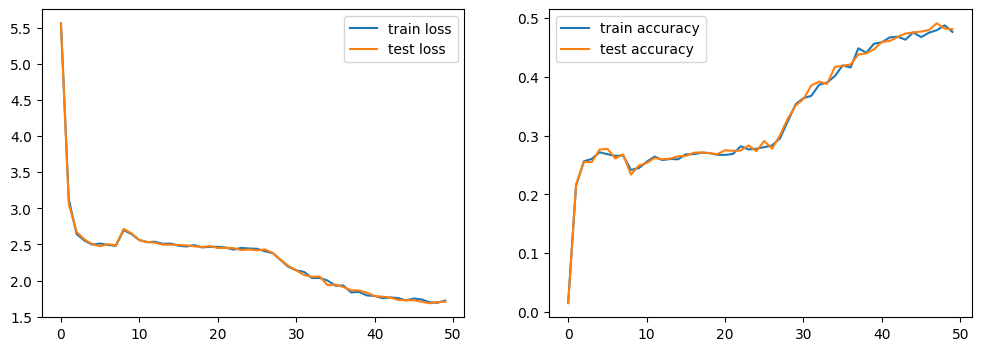

In [ ]:
train_steps = 1_000
batch_size = 32
context_size = 512
n_layers = 6
n_heads = 6
embedding_dim = 384
learning_rate = 1e-3
train_fraction = 0.9
dropout = 0.1

tokenizer = CharacterTokenizer()

dataset = CharacterDataset.from_textfile('./input.txt', context_size=context_size)
print(dataset)

model = GPT(context_size=context_size, tokenizer=tokenizer, n_layers=n_layers, embedding_dim=embedding_dim, n_heads=n_heads, dropout=dropout)
print(model)

model.to(DEVICE)
model.train()

train_dataset, test_dataset = random_split(dataset, [train_fraction, 1 - train_fraction])

train_dataloader = DataLoader(
    dataset=train_dataset,
    sampler=RandomSampler(train_dataset, num_samples=train_steps * batch_size),
    batch_size=batch_size,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    sampler=RandomSampler(test_dataset, replacement=True),
    batch_size=batch_size,
)
test_dataloader = iter(test_dataloader)

optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate, betas=(0.9, 0.99))
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, total_steps=train_steps)
model.train()

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for i, (train_x, train_y) in enumerate(tqdm(train_dataloader)):
    # forward the model
    _,train_loss,train_accuracy = model(train_x.to(DEVICE), train_y.to(DEVICE))

    # save losses on train and test every 20 iterations
    if i % 20 == 0:
        train_losses.append(train_loss.item())
        train_accuracies.append(train_accuracy.item())
        test_x, test_y = next(test_dataloader)
        _,test_loss,test_accuracy = model(test_x.to(DEVICE), test_y.to(DEVICE))
        test_losses.append(test_loss.item())
        test_accuracies.append(test_accuracy.item())

    # backprop and update the parameters
    model.zero_grad(set_to_none=True)
    train_loss.backward()

    # Prevent gradients from becoming too large
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

fig,[ax1, ax2] = plt.subplots(ncols=2, figsize=(12,4))
ax1.plot(train_losses, label='train loss')
ax1.plot(test_losses, label='test loss')
ax1.legend()
ax2.plot(train_accuracies, label='train accuracy')
ax2.plot(test_accuracies, label='test accuracy')
ax2.legend()

#### Evaluate
We let the trained model generate a piece of text that should somewhat resemble shakespeare. Compare to what was generated from the untrained model.

In [30]:
model.eval()
sample = model.generate()
print(sample)

Sampling:   0%|          | 0/256 [00:00<?, ?it/s]

Sampling: 100%|██████████| 256/256 [00:03<00:00, 76.09it/s] 


 
ARN:
Ay, what my Your by haster. You him sman in thyse is mecose that of adve: all be
Help the his in the with
I how more. O man:
Creasun a conse to such
going; nothers tame sissionibuck inst and prove sholdy sumany lear blucked can execieson frother
they


## Scaling up to increase performance
From the previous exercises you have probably noticed that with limited time and compute resources it is difficult to get the GPT model to generate text that resembles english language. To help you get a slightly better idea of the capabilities of our implementation, we have pretrained some models on a variety of datasets. The model implementation is the exact same, so you can load the weights using the `load_pretrained` classmethod. Below we download the files containing the weights and experiment a bit with the pretrained models.

In [ ]:
!wget -nc https://github.com/holmrenser/deep_learning/raw/refs/heads/main/war_peace_plain.model.pkl

### Exercise 5
Load each of the three pretrained models with the code below, note the model size and configuration, and generate a few samples. Make sure to change the prompt (`'prompt me'`) into something else. What do you notice when comparing the models? Can you have a conversation with any of the models?

In [ ]:
pretrained_model = GPT.load_pretrained('war_peace_plain.model.pkl')
print(pretrained_model)
pretrained_model.eval()
sample = pretrained_model.generate('prompt me')
print(sample)

GPT(num_params=10942720, context_size=512, vocab_size=256, n_attention_layers=6, n_heads=6, embedding_dim=384, dropout=0.1)


Sampling: 100%|██████████| 256/256 [00:02<00:00, 112.87it/s]

how are you doing?"

"I am very glad to have my son. Is he quite well?"

"Yes, I was. Have had a look at your head."

"Yes."

"But immediately, without a single force of me. He got up and got warm, tapping
his back to the edge of the bank. Involuntarily he turned to the
men
